In [7]:
# imports 
import re
import numpy as np
from copy import deepcopy
from timeit import default_timer as timer
import networkx as nx
import matplotlib.pyplot as plt
import random

ModuleNotFoundError: No module named 'numpy'

In [19]:
# generador mapas aleatorios de TSP.
class GeneradorEscenarios:
    def __init__(self):
        self.nombre = ""
        self.dimension = 0

    def generate_randmap(self, dimension):
        self.nombre = f'Aleatorio {dimension} nodos'
        self.dimension = dimension
        self.problema = {}
        for i in range(1, dimension + 1):
            self.problema[i] = round(random.random() * 50, 2), round(random.random() * 50, 2)
        self.solution = []
        self.solution = list(self.problema.keys())

    def save_scenario(self, filename):
        salida = "NAME: " + self.nombre + "\n"
        salida += "COMMENT: Randomly generated scenario\n"
        salida += "TYPE: TSP\n"
        salida += "DIMENSION: " + str(self.dimension) + "\n"
        salida += "EDGE_WEIGHT_TYPE: EUC-2D\n"
        salida += "NODE_COORD_SECTION\n"
        for ciudad in self.problema:
            salida += str(ciudad) + " " + str(self.problema[ciudad][0]) + " " + str(self.problema[ciudad][1]) + "\n"
        with open("./" + filename, 'w') as file:
            file.write(salida)
        return

CIUDADES_DESDE_DOS_HASTA_X = 500
NUMERO_ESCENARIOS_PARA_X_CIUDADES = 1

generador = GeneradorEscenarios()
for i in range(3, CIUDADES_DESDE_DOS_HASTA_X+1):
    for j in range(NUMERO_ESCENARIOS_PARA_X_CIUDADES):
        generador.generate_randmap(i)
        generador.save_scenario("random_"+str(i)+"nodes_"+str(j+1)+"_2opt.tsp")



SIMULATION ENDED.
Tour with length: 48 - [21, 11, 9, 19, 43, 8, 18, 14, 45, 22, 33, 41, 2, 31, 10, 39, 3, 36, 34, 15, 25, 20, 40, 26, 12, 44, 23, 47, 35, 46, 28, 38, 7, 13, 30, 32, 16, 5, 1, 0, 27, 49, 29, 6, 42, 24, 48, 4]
total cost: 357.13599544631177


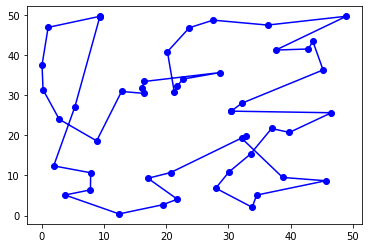

fin


In [26]:
# optimized code.
import numpy as np
import imageio
from numba import njit
import os



def parser(filepath):
  name = ""
  dimension = -1
  raw_data = []
  data = []
  with open(filepath, 'r', encoding='utf-8') as file:
    for line in file:
        if len(name) == 0 and 'NAME' in line:
            name = line.split(" ")[1].strip()
        if dimension == -1 and 'DIMENSION' in line:
            dimension = int(line.split(" ")[1].strip())
        if re.match(r'[ \d]+', line):
            raw_data.append(line.strip())
  for d in raw_data:
      data_splitted = d.split(" ")
      data.append((float(data_splitted[1]), float(data_splitted[2]), int(data_splitted[0]) ))
  return name, dimension, data


def draw_tour(tour, x, y, z):
    x_coord = []
    y_coord = []
    for t in tour:
      pos = np.where(z==t)
      x_coord.append(x[pos[0][0]])
      y_coord.append(y[pos[0][0]])
    pos = np.where(z == tour[0])
    x_coord.append(x[pos[0][0]])
    y_coord.append(y[pos[0][0]])
    plt.plot(x_coord,y_coord, 'bo-')
    plt.show()
    plt.close()

@njit
def get_neighbourhood(winner):
    if winner == 0:
       return [OUTPUT_SIZE-1, 1]
    if winner == OUTPUT_SIZE-1:
       return [winner-1, 0]
    return [winner-1, winner+1]

# ===========
@njit
def normalize(x, y):
    X_N = np.zeros(DIMENSION)
    Y_N = np.zeros(DIMENSION)
    x_max = np.max(x)
    x_min = np.min(x)
    y_max = np.max(y)
    y_min = np.min(y)
    for i in range(0, DIMENSION):
        X_N[i] = (x[i] - x_min) / (x_max - x_min)
        Y_N[i] = (y[i] - y_min) / (y_max - y_min)
    return X_N, Y_N

@njit
def fullfil_adjacency_matrix(matrix, dimension, x, y):
    for i in range(0, dimension):
       for j in range(0, dimension):
           matrix[i][j] = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
    return matrix

@njit
def evaluate_cost(tour, matrix):
    total_cost = 0
    limit = len(tour) - 1
    for i in range(0, limit):
        total_cost += matrix[tour[i]][tour[i + 1]]
    total_cost += matrix[tour[limit]][tour[0]]
    return total_cost

@njit
def get_winner_cell(weights, entry, osize, isize):
    distances = np.zeros(osize)
    for i in range(0, osize):
      for j in range(0, isize):
        distances[i] += (entry[j] - weights[j][i])**2
    distances = distances**0.5
    return np.argmin(distances)

@njit
def update_weights(weights, entry, isize, winner, lr, neigh_decay):
   for i in range(0, isize):
      weights[i][winner] += ( lr * (entry[i] - weights[i][winner]))
   for n in get_neighbourhood(winner):
      for i in range(0, isize):
          weights[i][n] += ( neigh_decay * lr * (entry[i] - weights[i][n]))

@njit
def figure_out_tour(dimension, osize, weights, x, y, z):
    tour = []
    for i in range(0, osize):
      for j in range(0, dimension):
          if round(x[j], 2) == round(weights[0][i], 2) and round(y[j], 2) == round(weights[1][i], 2):
              if z[j] not in tour:
                  tour.append(z[j])
    return tour


@njit
def run_iteration(dimension, x_norm, y_norm, weights, osize, isize, lr, neigh_decay):
  for i in range(0, dimension):
    entry = (x_norm[i], y_norm[i])
    winner = get_winner_cell(weights, entry, osize, isize)
    update_weights(weights, entry, isize, winner, lr, neigh_decay)



# ==============================
#CODE


NAME, DIMENSION, DATA = parser("random_50nodes_1_2opt.tsp")
X = np.asarray([city[0] for city in DATA])
Y = np.asarray([city[1] for city in DATA])
Z = np.asarray([city[2]-1 for city in DATA])

X_NORM, Y_NORM = normalize(X,Y)
ADJACENT_MATRIX = fullfil_adjacency_matrix(np.zeros((DIMENSION, DIMENSION)), DIMENSION, X, Y)

ITERS_PER_ROUND = 5000
INPUT_SIZE = 2
OUTPUT_SIZE = int(DIMENSION * 1.75)


tour = []
xxxx = 1
# while len(tour) != DIMENSION:
while xxxx != 0:
    xxxx -= 1
    # FOR EACH TRY, RESET ALL KSOM.

    # pesos aleatorios, pesos distribuidos uniformemente sobre un espacio dado

    #weights = np.random.rand(INPUT_SIZE, OUTPUT_SIZE)
    #weights = np.random.uniform(0.45, 0.55, (INPUT_SIZE, OUTPUT_SIZE))

    # generamos un anillo de neuronas con un determinado radio y lo colocamos
    # en 0.5, 0.5 el centro del anillo. 
    theta = np.linspace(0, 2*np.pi, OUTPUT_SIZE)
    radius = 0.05
    
    x = radius * np.cos(theta) + 0.5
    y = radius * np.sin(theta) + 0.5

    weights = np.zeros((2, OUTPUT_SIZE))
    for i in range(0, OUTPUT_SIZE):
      weights[0][i] = x[i]
    for i in range(0, OUTPUT_SIZE):
      weights[1][i] = y[i]

    lr = 0.99
    const = 0.0000015
    beta = lr / ITERS_PER_ROUND #constant factor that decrements the lr.
    neigh_beta = 0.5 / ITERS_PER_ROUND 
    

    for iter in range(0, ITERS_PER_ROUND):
        #"""
        if iter % 25 == 0:
          plt.plot(X_NORM, Y_NORM, 'ro', label="entradas")
          plt.plot(weights[0,], weights[1,], 'bo', label="centroides")
          plt.fill(weights[0,], weights[1,], edgecolor='b', fill=False)
          plt.suptitle(f"TSP KSOM - cities:{DIMENSION}")
          plt.title(f"current iteration:{iter}")
          #plt.show()
          plt.savefig(f"{iter}_im.png")
          plt.close()
        #"""
        
        aux_lr = lr * (np.exp(1)**(-iter*const))
        #aux_lr = lr - iter*beta
        neigh_decay = 0.5 - iter * neigh_beta
        #neigh_decay = 0.5 * (np.exp(1)**(-iter*neigh_beta))

        #run_iteration(DIMENSION, X_NORM, Y_NORM, weights, OUTPUT_SIZE, INPUT_SIZE, aux_lr, neigh_decay)
        #"""
        #for i in range(0, DIMENSION):
        i = np.random.randint(0, DIMENSION)
        entry = (X_NORM[i], Y_NORM[i])
        winner = get_winner_cell(weights, entry, OUTPUT_SIZE, INPUT_SIZE)
        update_weights(weights, entry, INPUT_SIZE, winner, aux_lr, neigh_decay)
        #"""
    tour = figure_out_tour(DIMENSION, OUTPUT_SIZE, weights, X_NORM, Y_NORM, Z)
    #print(f"Tour found with length: {len(tour)} - {tour}")
    #draw_tour(tour, X, Y, Z)

    #"""  
    with imageio.get_writer("sample_data/results.gif", mode='I') as writer:
        filenames = []
        for i in range(0, ITERS_PER_ROUND):
            #for j in range(0, OUTPUT_SIZE):
            if i % 25 == 0:
              #filenames.append(f"{i}_{j}_im.png")
              filenames.append(f"{i}_im.png")
        
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    #"""

#"""
filenames = []
for i in range(0, ITERS_PER_ROUND):
  if i % 25 == 0:
    filenames.append(f"{i}_im.png")
for file in filenames:
  os.remove(file)
#"""

print("SIMULATION ENDED.")
print(f"Tour with length: {len(tour)} - {tour}")
print(f"total cost: {evaluate_cost(np.asarray(tour), ADJACENT_MATRIX)}")
draw_tour(tour, X, Y, Z)
print("fin")